In [ ]:
# === White Dwarf Gaia DR3 Analysis ===
# Author: Maura E. Ramirez - Quezada (with ChatGPT assistance)
# Description: Carga, limpieza y visualización inicial de datos de enanas blancas de Gaia WDR3

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# === 1. Required Libraries ===
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import numpy as np
from scipy.interpolate import LinearNDInterpolator
import plot_styles as plts
import constants as cs
import cooling_curves as cc

## Exploring the Gaia file

### Main data set of WDs

In [3]:
# === 2. Path to the FITS file ===
fits_path = 'gaiaedr3_wd_main.fits'

# === 3. Load data using Astropy ===
with fits.open(fits_path) as hdul:
    table = Table(hdul[1].data)

In [4]:
# === 4. Convert to Pandas DataFrame ===
df = table.to_pandas()
print("Data loaded:", df.shape)

# === 5. Initial Exploration ===
print("Available columns:\n", df.columns.tolist())
print(df.describe())


Data loaded: (1280266, 161)
Available columns:
 ['WDJ_name', 'source_id', 'dr2_source_id', 'designation', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'ZP_correction', 'Pwd', 'density', 'solution_id', 'random_index', 'ref_epoch', 'pm', 'pm_err', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'nu_eff_used_in_astrometry', 'pseudocolour', 'pseudocolour_error', 'ra_pseudocolour_corr', 'dec_pseudocolour_corr', 'parallax_pseudocolour_corr', 'pmra_pseudocolour_corr', 'pmdec_pseudocolour_corr', 'astrome

###  Cross-match with SDSS DR16 spectroscopy

In [5]:

# Replace with your actual path
gentile_fits_path = 'gaiaedr3_wd_sdssspec.fits'

with fits.open(gentile_fits_path) as hdul:
    gentile_data = Table(hdul[1].data).to_pandas()

print(gentile_data.columns.tolist())
gentile_data.head()


['WDJ_name', 'source_id', 'dr2_source_id', 'WD_catalogue', 'ra', 'dec', 'parallax', 'parallax_error', 'Pwd', 'PHwd', 'phot_g_mean_mag', 'phot_g_mean_mag_error', 'phot_bp_mean_mag', 'phot_bp_mean_mag_error', 'phot_rp_mean_mag', 'phot_rp_mean_mag_error', 'teff_H', 'eteff_H', 'logg_H', 'elogg_H', 'mass_H', 'emass_H', 'chisq_H', 'teff_He', 'eteff_He', 'logg_He', 'elogg_He', 'mass_He', 'emass_He', 'chisq_He', 'teff_mixed', 'eteff_mixed', 'logg_mixed', 'elogg_mixed', 'mass_mixed', 'emass_mixed', 'chisq_mixed', 'SDSS12', 'sdss_clean', 'umag', 'e_umag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag', 'SDSS_separation', 'SDSS_spec', 'Plate', 'MJD', 'FiberID', 'S/N', 'spec_class']


,WDJ_name,source_id,dr2_source_id,WD_catalogue,ra,dec,parallax,parallax_error,Pwd,PHwd,...,e_imag,zmag,e_zmag,SDSS_separation,SDSS_spec,Plate,MJD,FiberID,S/N,spec_class
0,WDJ121037.45+140644.34,3920930517021000064,3920930517021000064,M,182.655813,14.112347,7.545117,0.732332,0.98737,-32768,...,0.022,19.788,0.064,0.093603,1,5392,56010,288,7,pecDQ
1,WDJ133359.84+001655.03,3662951038644235776,3662951038644235776,M,203.497875,0.282887,24.453345,0.198643,1.00000,-32768,...,0.009,18.235,0.028,0.078416,2,298,51955,492,5,pecDQ
2,WDJ133359.84+001655.03,3662951038644235776,3662951038644235776,M,203.497875,0.282887,24.453345,0.198643,1.00000,-32768,...,0.009,18.235,0.028,0.078416,2,298,51662,484,4,pecDQ
3,WDJ101141.58+284559.07,740483560857296768,740483560857296768,M,152.922607,28.763239,67.879416,0.057067,1.00000,-32768,...,0.004,15.995,0.007,0.076985,2,3260,54883,332,1,pecDQ
4,WDJ101141.58+284559.07,740483560857296768,740483560857296768,M,152.922607,28.763239,67.879416,0.057067,1.00000,-32768,...,0.004,15.995,0.007,0.076985,2,2348,53757,500,8,pecDQ


### Visualizing data

In [10]:
# === 6. Select relevant columns for Hydrogen atmosphere model ===
cols_H = ['teff_H', 'mass_H', 'logg_H','source_id','WDJ_name']
df_H = df[cols_H].copy()
df_H.dropna(inplace=True)

In [38]:
df_H['WDJ_name']

0          WDJ235959.90+512337.51 
2          WDJ235959.49-034703.60 
3          WDJ235959.48+082813.10 
5          WDJ235958.84-213149.25 
6          WDJ235958.62+301622.51 
                    ...           
1280249    WDJ000002.89+230847.67 
1280250    WDJ000002.86-631934.14 
1280251    WDJ000002.54-173501.29 
1280256    WDJ000001.78-423821.64 
1280259    WDJ000001.68-502431.29 
Name: WDJ_name, Length: 298317, dtype: object

/var/folders/y8/6tlplz1d2w1dk6qd5rz9z4m80000gn/T/ipykernel_22663/2722116129.py:4: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.subplot(1, 3, 1)
/var/folders/y8/6tlplz1d2w1dk6qd5rz9z4m80000gn/T/ipykernel_22663/2722116129.py:9: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.subplot(1, 3, 2)
/var/folders/y8/6tlplz1d2w1dk6qd5rz9z4m80000gn/T/ipykernel_22663/2722116129.py:14: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.subplot(1, 3, 3)
/var/folders/y8/6tlplz1d2w1dk6qd5rz9z4m80000gn/T/ipykernel_22663/2722116129.py:19: UserWarning: Glyph 9737 (\N{SUN}) missing from font(s) cmr10.
  plt.tight_layout()
/Users/ramirezmaura/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9737 (\N{SUN}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


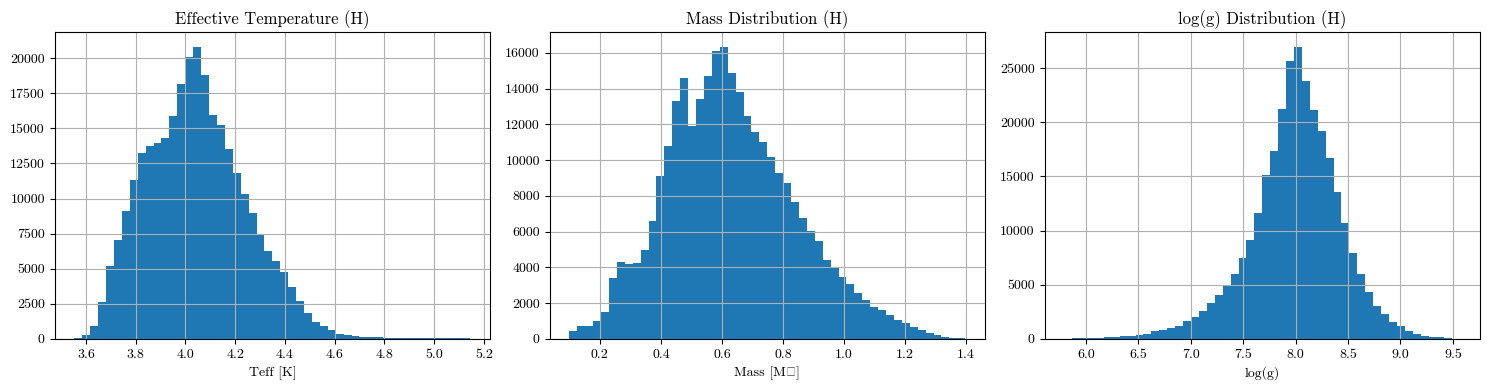

In [12]:

# === 7. Visualization ===
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
np.log10(df_H['teff_H']).hist(bins=50)
plt.xlabel('Teff [K]')
plt.title('Effective Temperature (H)')

plt.subplot(1, 3, 2)
df_H['mass_H'].hist(bins=50)
plt.xlabel('Mass [M☉]')
plt.title('Mass Distribution (H)')

plt.subplot(1, 3, 3)
df_H['logg_H'].hist(bins=50)
plt.xlabel('log(g)')
plt.title('log(g) Distribution (H)')

plt.tight_layout()
plt.show()



## Filltering of data

In [13]:
# === 8. Filter stars within 13 parsecs (as used in the 2025 paper) ===
df_close = df[df['r_med_geo'] <= 50].copy()
print(f"\nNumber of stars within 25 pc: {df_close.shape[0]}")

# Apply the same selection for valid Hydrogen atmosphere models
df_close_H = df_close[['teff_H', 'mass_H', 'logg_H', 'r_med_geo']].copy()
df_close_H.dropna(inplace=True)
print(f"Number of close stars with full physical parameters: {df_close_H.shape[0]}")


Number of stars within 25 pc: 2151
Number of close stars with full physical parameters: 2119


/var/folders/y8/6tlplz1d2w1dk6qd5rz9z4m80000gn/T/ipykernel_22663/2740318769.py:4: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.subplot(1, 3, 1)
/var/folders/y8/6tlplz1d2w1dk6qd5rz9z4m80000gn/T/ipykernel_22663/2740318769.py:9: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.subplot(1, 3, 2)
/var/folders/y8/6tlplz1d2w1dk6qd5rz9z4m80000gn/T/ipykernel_22663/2740318769.py:14: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  plt.subplot(1, 3, 3)
/var/folders/y8/6tlplz1d2w1dk6qd5rz9z4m80000gn/T/ipykernel_22663/2740318769.py:19: UserWarning: Glyph 9737 (\N{SUN}) missing from font(s) cmr10.
  plt.tight_layout()
/Users/ramirezmaura/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9737 (\N{SUN}) missing from font(s) cmr10.
  fig.canvas.print_figure(bytes_io, **kw)


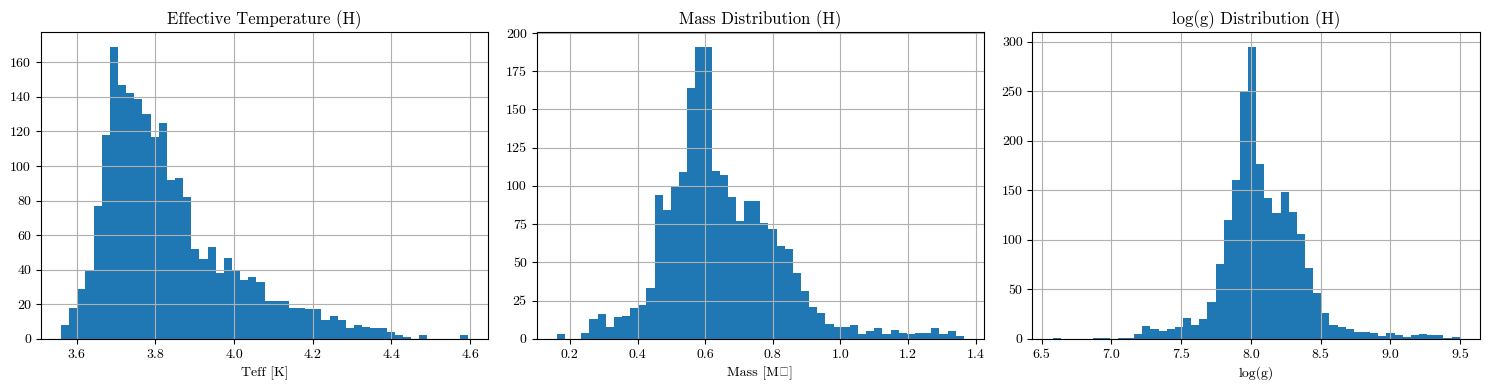

In [14]:

# === 9. Visualization ===
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
np.log10(df_close['teff_H']).hist(bins=50)
plt.xlabel('Teff [K]')
plt.title('Effective Temperature (H)')

plt.subplot(1, 3, 2)
df_close['mass_H'].hist(bins=50)
plt.xlabel('Mass [M☉]')
plt.title('Mass Distribution (H)')

plt.subplot(1, 3, 3)
df_close['logg_H'].hist(bins=50)
plt.xlabel('log(g)')
plt.title('log(g) Distribution (H)')

plt.tight_layout()
plt.show()


### Checking Magnetic and binary WDs

In [15]:
# Exclude all spectral types that either:
# (1) contain an 'H' anywhere in the class name (e.g., DAH, DBH, etc.)
# (2) are explicitly labeled as 'MWD'
gentile_data['spec_class'] = gentile_data['spec_class'].astype(str).str.upper()

magnetic_mask = gentile_data['spec_class'].str.upper().str.contains('H', na=False) | \
                (gentile_data['spec_class'] == 'MWD')

non_magnetic_stars = gentile_data[~magnetic_mask]

print(f"Non-magnetic WDs found: {non_magnetic_stars.shape[0]}")


Non-magnetic WDs found: 41681


In [16]:
# Ensure spec_class is uppercase and valid string
gentile_data['spec_class'] = gentile_data['spec_class'].astype(str).str.upper()

# Step 1: Flag all magnetic WDs
magnetic_mask = gentile_data['spec_class'].str.contains('H', na=False) | \
                (gentile_data['spec_class'] == 'MWD')
magnetic_stars = gentile_data[magnetic_mask].copy()

# Step 2: Mark magnetic stars in df_close
df_close = df_close.copy()
df_close['source_id'] = df_close['source_id'].astype(np.int64)
magnetic_stars['source_id'] = magnetic_stars['source_id'].astype(np.int64)
df_close['is_magnetic'] = df_close['source_id'].isin(magnetic_stars['source_id'])


### Checking WDs with companion

In [17]:
# Step 3: Mark isolated WDs
binary_classes = [
    'DA_MS', 'DA_MS:', 'DB_MS', 'DC_MS',
    'CV', 'DA_DQ', 'DBAH', 'DABZ', 'DBAZ', 'DZAB', 'DZBA', 'DZB'
]
isolated_stars = gentile_data[~gentile_data['spec_class'].isin(binary_classes)].copy()
isolated_stars['source_id'] = isolated_stars['source_id'].astype(np.int64)
df_close['is_isolated'] = df_close['source_id'].isin(isolated_stars['source_id'])


In [18]:

# Step 4: Combine both filters
df_clean = df_close[(df_close['is_magnetic'] == False) & (df_close['is_isolated'] == True)]

# Step 5: Final physical subset
df_clean_H = df_clean[['source_id','teff_H', 'mass_H', 'logg_H', 'r_med_geo']].dropna().copy()

print(f"Non-magnetic, isolated WDs with full physical parameters: {df_clean_H.shape[0]}")


Non-magnetic, isolated WDs with full physical parameters: 151


In [19]:
# Check final spec_class labels in the 7 surviving WDs
merged_check = df_clean_H.merge(
    gentile_data[['source_id', 'spec_class']],
    on='source_id',
    how='left'
)

print("Spectral types in the final filtered sample:")
print(merged_check['spec_class'].value_counts())

Spectral types in the final filtered sample:
spec_class
DA        118
DC         32
DQ         13
DZ          9
UNRELI      7
MWD         6
PECDQ       3
WD          2
DC_MS       2
DAZ         2
WDPEC       2
UNKN        1
DZA         1
STAR        1
Name: count, dtype: int64


In [31]:
# Merge spec_class to include spectral type
final_sample = df_clean_H.merge(
    gentile_data[['source_id', 'spec_class']],
    on='source_id',
    how='left'
)

# Set full display for all columns
with pd.option_context('display.max_columns', None):
    print(final_sample)


               source_id     teff_H    mass_H    logg_H  r_med_geo spec_class
0    2645480299903701504   6558.208  0.723417  8.211992  45.277195     DA    
1    1884744525522874880   5635.304  0.428488  7.678237  19.977541     DA    
2    2836609093355562496  10533.870  1.020744  8.661232  17.817511     DA    
3    2836609093355562496  10533.870  1.020744  8.661232  17.817511     DA    
4    1888836972229230976   6046.962  0.745623  8.248495  46.776775     UNRELI
..                   ...        ...       ...       ...        ...        ...
194  2545505281002947200   9528.395  0.591750  7.987608  39.920338     DA    
195  2545505281002947200   9528.395  0.591750  7.987608  39.920338     DA    
196  2545505281002947200   9528.395  0.591750  7.987608  39.920338     DA    
197  2545505281002947200   9528.395  0.591750  7.987608  39.920338     DA    
198  2447889401738675072   6970.092  0.555713  7.938805  46.921658     DA    

[199 rows x 6 columns]


## Radius calculation

In [32]:
# === Physical constants ===
G_cgs = cs.G_cgs      # cm^3 g^-1 s^-2
M_sun_g = cs.M_sun_g     # g
R_earth_cm = cs.R_earth_cm    # cm

# === Compute surface gravity and mass in CGS units ===
final_sample['g_cgs'] = 10 ** final_sample['logg_H']
final_sample['mass_g'] = final_sample['mass_H'] * M_sun_g

# === Compute radius in cm ===
final_sample['radius_cm'] = np.sqrt(G_cgs * final_sample['mass_g'] / final_sample['g_cgs'])

# === Convert radius to Earth radii ===
final_sample['radius_earth'] = final_sample['radius_cm'] / R_earth_cm

# === Display result ===
with pd.option_context('display.max_columns', None):
    print(final_sample[['source_id', 'teff_H', 'mass_H', 'logg_H', 'radius_earth', 'spec_class']])



               source_id     teff_H    mass_H    logg_H  radius_earth  \
0    2645480299903701504   6558.208  0.723417  8.211992      1.203565   
1    1884744525522874880   5635.304  0.428488  7.678237      1.712466   
2    2836609093355562496  10533.870  1.020744  8.661232      0.852341   
3    2836609093355562496  10533.870  1.020744  8.661232      0.852341   
4    1888836972229230976   6046.962  0.745623  8.248495      1.171611   
..                   ...        ...       ...       ...           ...   
194  2545505281002947200   9528.395  0.591750  7.987608      1.409407   
195  2545505281002947200   9528.395  0.591750  7.987608      1.409407   
196  2545505281002947200   9528.395  0.591750  7.987608      1.409407   
197  2545505281002947200   9528.395  0.591750  7.987608      1.409407   
198  2447889401738675072   6970.092  0.555713  7.938805      1.444754   

    spec_class  
0       DA      
1       DA      
2       DA      
3       DA      
4       UNRELI  
..         ...  
194 

/var/folders/y8/6tlplz1d2w1dk6qd5rz9z4m80000gn/T/ipykernel_19341/3032666869.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(6, 5))


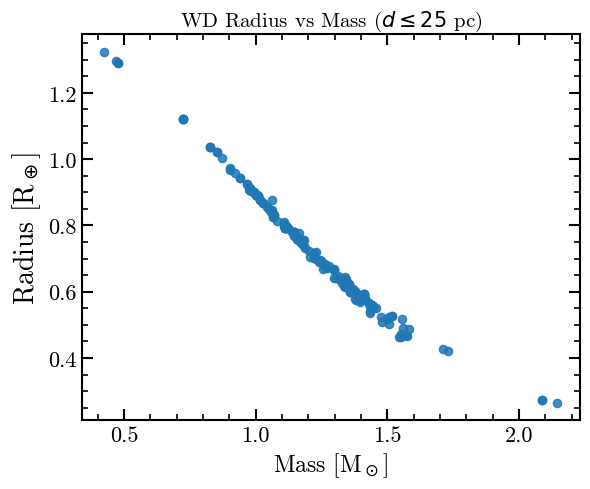

In [106]:
# === Mass vs Radius plot for filtered WDs ===

fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(
    final_sample['radius_earth'],
    final_sample['mass_H'],
    s=35,
    edgecolor=None,
    alpha=0.85
)

plts.apply_standard_formatting(
    ax,
    xlog=False,
    ylog=False,
    xlabel=r'Mass [M$_\odot$]',
    ylabel=r'Radius [R$_\oplus$]',
    title=r'WD Radius vs Mass ($d \leq 25$ pc)'
)

plt.tight_layout()
plt.show()




In [39]:
# Filter: masses > 0.8 M_sun
massive_wds = final_sample[final_sample['mass_H'] > 0.8]

# Sort by effective temperature ascending (coldest first)
coldest_massive_wds = massive_wds.sort_values(by='teff_H', ascending=True)

# Take the 10 coldest
top10_coldest_massive = coldest_massive_wds.head(5)


In [36]:
columns_to_save = [
    'source_id', 'teff_H', 'mass_H', 'logg_H', 'radius_earth', 'spec_class'
]

coolest_wds_export = top10_coldest_massive[columns_to_save]


In [37]:
coolest_wds_export.to_csv(
    'coolest_wds_profiles.dat',
    sep=' ',  # también puedes usar '\t' para tabulado
    index=False,
    float_format='%.6e'  # formato científico con 6 decimales
)


## WD Luminosity

In [54]:
# Compute radius in cm
final_sample['radius_cm'] = final_sample['radius_earth'] * cs.R_earth_cm  # 1 R⊕ in cm

# Compute luminosity in erg/s
final_sample['luminosity_erg'] = 4 * np.pi * (final_sample['radius_cm'] ** 2) * cs.sigma_sb * (final_sample['teff_H'] ** 4)

In [55]:
final_sample = final_sample.merge(
    df_H[['source_id', 'WDJ_name']],
    on='source_id',
    how='left'
)


In [77]:
# Filter WDs with mass > 0.8 Msun
massive_wds = final_sample[(final_sample['mass_H'] > 0.8) &
                           (final_sample['spec_class'].str.strip() == 'DA')]
# Sort by Teff ascending (coolest first), then by mass descending (most massive first)
final_sample_sorted = massive_wds.sort_values(
    by=['teff_H', 'mass_H'],
    ascending=[True, False]  # True = lowest Teff first, False = highest mass first
).reset_index(drop=True)


/var/folders/y8/6tlplz1d2w1dk6qd5rz9z4m80000gn/T/ipykernel_22663/4193362787.py:3: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ax = plt.subplots(figsize=(7, 5))
/var/folders/y8/6tlplz1d2w1dk6qd5rz9z4m80000gn/T/ipykernel_22663/4193362787.py:24: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = plt.colorbar(scatter, ax=ax, pad=0.02, shrink=0.9)


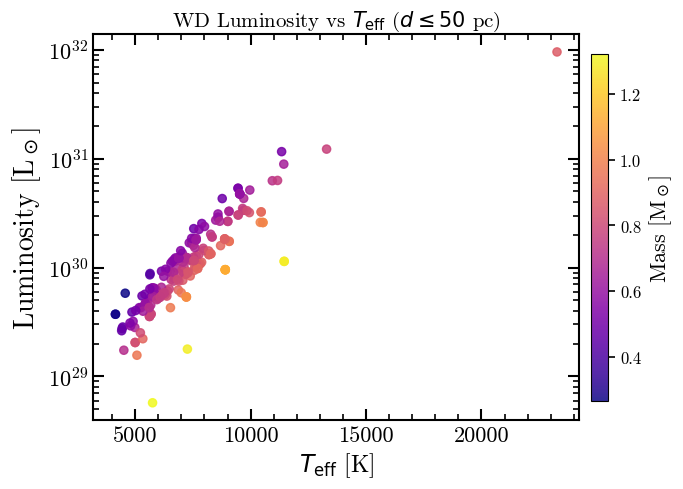

In [43]:
# === Diagnostic plots for WDs within 25 pc ===

fig, ax = plt.subplots(figsize=(7, 5))

scatter = ax.scatter(
    final_sample['teff_H'],
    final_sample['luminosity_erg'],
    c=final_sample['mass_H'],
    cmap='plasma',
    s=35,
    edgecolor=None,
    alpha=0.85
)

plts.apply_standard_formatting(
    ax,
    xlog=False,
    ylog=True,
    xlabel=r'$T_\mathrm{eff}$ [K]',
    ylabel=r'Luminosity [L$_\odot$]',
    title=r'WD Luminosity vs $T_{\mathrm{eff}}$ ($d \leq 50$ pc)'
)

cbar = plt.colorbar(scatter, ax=ax, pad=0.02, shrink=0.9)
cbar.ax.tick_params(labelsize=12, width=1.2, length=5)
cbar.set_label(r'Mass [M$_\odot$]', fontsize=16)

plt.tight_layout()

plt.show()

## WD age & $T_c$: Cooling models

### WD central pressure & density

In [48]:
# Step 1: Extract core values from WD profile files
df_core = cc.extract_core_values_from_profiles("Profiles")


In [50]:

# Step 2: Load your main WD catalog
df_coolest = pd.read_csv("Profiles/coolest_wds_profiles.dat", sep=" ")

In [52]:

# Step 3: Merge both by nearest mass match
df_final = cc.merge_with_tolerant_mass(df_coolest, df_core, mass_col="mass_Msun")

In [142]:

# Step 4: Save the updated catalog with central values
df_final.to_csv("Profiles/coolest_wds_profiles_with_core.dat", sep="\t", index=False)


### WD central temperature & age

In [3]:

# Load your file with the WD parameters
df_coolest = pd.read_csv("Profiles/coolest_wds_profiles_with_core.dat", sep="\t")

In [4]:
# Create empty columns to store results
df_coolest["logTc"] = None
df_coolest["Tc_K"] = None
df_coolest["Age_Gyr"] = None
df_coolest["interp_from"] = None
df_coolest["interp_to"] = None

In [5]:

# Loop through each row and apply your interpolation function
for idx, row in df_coolest.iterrows():
    interp_model, f1, f2 = cc.interpolate_model_between_masses(
        folder="AllSequences",
        tipo_espectral="DA",
        target_mass=row["mass_Msun"],
        tolerance=0.03,
        Teff=row["teff_K"],
        logg=row["log(g)"],
        logPc= np.log(row["P_c"]), 
        #logRho_c=np.log10(row["rho_c"])
    )

    if interp_model:
        df_coolest.at[idx, "logTc"] = interp_model["logTc"]
        df_coolest.at[idx, "Tc_K"] = 10**interp_model["logTc"]
        df_coolest.at[idx, "Age_Gyr"] = interp_model["Age_s"] / 1e9
        # df_coolest.at[idx, "interp_from"] = f1
        # df_coolest.at[idx, "interp_to"] = f2

# Save result
#df.to_csv("coolest_wds_profiles_with_all_outputs.dat", sep="\t", index=False)


In [152]:
# Save result
df_coolest.to_csv("Profiles/coolest_wds_profiles_with_all_outputs.dat", sep=" ", index=False)